# Rollback Reason Predictor classifier

In [1]:
# importing all the libraries
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from tqdm import tqdm_notebook as tqdm
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report,confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ranji\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Fetching the Manually segregated Dataset


In [2]:
df_add = pd.read_csv("C:/Users/ranji/Desktop/SE/Project/Manual analysis/added.csv")
df_format = pd.read_csv("C:/Users/ranji/Desktop/SE/Project/Manual analysis/Format errors.csv")
df_grammer = pd.read_csv("C:/Users/ranji/Desktop/SE/Project/Manual analysis/grammer.csv")
df_spam = pd.read_csv("C:/Users/ranji/Desktop/SE/Project/Manual analysis/spam.csv")
df_typo = pd.read_csv("C:/Users/ranji/Desktop/SE/Project/Manual analysis/typo errors.csv")


In [3]:
df_dataset = pd.concat([df_add, df_format, df_grammer, df_spam, df_typo], axis=0)

In [4]:
df_dataset = df_dataset.drop(["Unnamed: 0"], axis=1)


In [5]:
# shuffling the dataset
df_dataset = shuffle(df_dataset)

In [7]:
df_dataset.head(10)

,data,label
346,i have a big number of `Polygons` extracted fr...,grammatic errors
201,I am a new leaner of C++ and I got stuck on on...,added or removed
257,"To solve this problem, it took me about three ...",grammatic errors
153,I wanted to compare reading lines of string in...,grammatic errors
77,If you want do insert ellipsis dependent on th...,spam
419,"Here is a Go program:\r\n\r\n~~~go\r\nimport ""...",typo errors
205,Recently I wanted to learn Node.js to help me ...,typo errors
72,Usually you would use `np.argwhere(e == 2)`:\r...,added or removed
500,I'm stuck trying to clear up lag and timing is...,added or removed
78,I have a list of location items (as `<li>` ele...,typo errors


## Dataset class-wise count before resampling

In [9]:
df_dataset["label"].value_counts()

added or removed    1285
grammatic errors     460
typo errors          435
Format errors        224
spam                 112
Name: label, dtype: int64

In [10]:
df_Filtered_data = df_dataset["data"]
df_Filtered_label =  df_dataset["label"]
df_X = list(df_Filtered_data.copy())
df_y = list(df_Filtered_label.copy())

## Data Pre-processing 

In [39]:
# since removal of contractions and lemmatization reduced the performance of the model, they were not included
def text_preprocess(ds):
    result = []
    for m in tqdm(ds):
        main_words = m.split()        
    
        #remove contractions "don't -> do not"
        #main_words = [contractions.fix(w) for w in main_words if len(w) > 1]
        
        # Remove stopwords
        main_words = [w for w in main_words if not w in set(stopwords.words('english'))]  
        
         
        # Group different forms of the same word
        #lem = WordNetLemmatizer()
        #main_words = [lem.lemmatize(w) for w in main_words if len(w) > 1]     
        
        #adding the questions length as an additional feature

        main_words = ' '.join(main_words)
        result.append(main_words)
        

    return result

In [40]:
pre_processedData = text_preprocess(df_X)

<ipython-input-39-374f9acd2b6f>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for m in tqdm(ds):


## Dataset Vectorization

In [44]:
#Extracting the bag of words for vectorization
bag_of_words = []
for i in tqdm(pre_processedData):
    lis = i.split()
    for j in lis:
        if j not in bag_of_words:
            bag_of_words.append(j)

<ipython-input-44-166c890c4178>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(pre_processedData):


In [45]:
# Building a TF IDF matrix out of the bag of words

td = TfidfVectorizer()
Vectorized_X = td.fit(bag_of_words)


In [46]:
# Resampling the data and getting train and test sets 
from imblearn.over_sampling import RandomOverSampler

# Vectorize the input data
Questions_Vectorized= Vectorized_X.transform(df_X)

# Only the minority classes are resampled
resample_data = RandomOverSampler(sampling_strategy='not majority', random_state=5)

# The data is fit into the seleted resampler
X_resampled, y_resampled = resample_data.fit_resample(Questions_Vectorized, df_y)
# The resampled data is split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, y_resampled, test_size=0.2,random_state=20)

## Dataset class-wise count after resampling

In [47]:
resample_label_train = pd.DataFrame()
resample_label_train["label"] = Y_train

In [48]:
resample_label_train.value_counts()

label           
typo errors         1043
grammatic errors    1036
Format errors       1028
spam                1027
added or removed    1006
dtype: int64

# Training and evaluating the LogisticRegression classifier


 Modle's Accuracy:  84.98 %

Classification Report

                   precision    recall  f1-score   support

   Format errors       0.87      0.95      0.91       257
added or removed       0.81      0.68      0.74       279
grammatic errors       0.81      0.80      0.80       249
            spam       0.94      0.98      0.96       258
     typo errors       0.81      0.85      0.83       242

        accuracy                           0.85      1285
       macro avg       0.85      0.85      0.85      1285
    weighted avg       0.85      0.85      0.85      1285


Confusion Matrix


<AxesSubplot:>

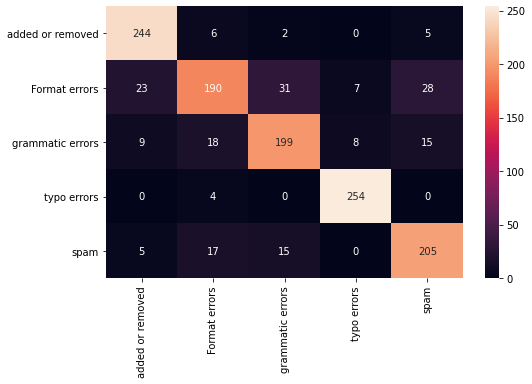

In [49]:
# Logistic regression for classifier
classifier = LogisticRegression(solver='lbfgs', max_iter=1000)
classifier.fit(X_train, Y_train)


# Classification metrics
y_pred = classifier.predict(X_test)
from sklearn.metrics import accuracy_score, classification_report
classification_report = classification_report(Y_test, y_pred)

print("\n Modle's Accuracy: ", (round((accuracy_score(Y_test, y_pred))*100,2)),"%")
print('\nClassification Report')
print('======================================================')
print('\n', classification_report)


cm = confusion_matrix(Y_test,y_pred)


df_cm = pd.DataFrame(cm, index = [i for i in list(set(Y_train))],
                  columns = [i for i in list(set(Y_train))])
plt.figure(figsize = (8,5))
print('\nConfusion Matrix')
print('======================================================')
sn.heatmap(df_cm, annot=True,  fmt='g')

